In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
import math
import random
import copy
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class REINFORCE():
    def __init__(self, grid_map_world, alpha=0.1, epsilon=0.9):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.theta_map = np.full((self.grid_map.shape[0], self.grid_map.shape[1], 9), 100.0, dtype=np.float)    #各グリッドにおける方策，初期値1＝右方向
        self.alpha = alpha
        self.epsilon = epsilon
        
        for x, grids in enumerate(self.grid_map):
            for y, grid in enumerate(grids):
                if(self.isGoal([x, y])):
                    self.theta_map[x][y] = [100, 0, 0, 0, 0, 0, 0, 0, 0]    #ゴールでの方策は「停止」
        self.min_length = float('inf')
    
    def draw(self, ax, elems):
        s_ = copy.copy(self.world.start_index)
        traversed_grids = np.zeros((0, 2), dtype=np.int8)
        g = 0
        step = 600
        move = 0
        g = -100
        for i in range(1, step+1):
            s = copy.copy(s_)
            a = self.greedyPolicy(s)    #方策
            s_ = self.moveRobot(s, a)   #移動
            
            traversed_grids = np.append(traversed_grids, [[copy.copy(s), a]], axis=0)
            if(self.isOutOfBounds(s_) or self.isObstacle(s_)):
                g = -100
                break
            elif(self.isGoal(s_)):
                g = 1
                break
        self.updatePolicy(traversed_grids, i, g)
        self.drawTraversedPath(traversed_grids, ax, elems)
#         dis_str ="Gt= %.4f" % (g)
#         elems.append(
#             ax.text(
#                 self.world.grid_step[0]*self.world.grid_num[0]*0.6,
#                 self.world.grid_step[1]*self.world.grid_num[1]*1.02,
#                 dis_str,
#                 fontsize=10
#             )
#         )
        self.drawMaxPolicy(ax, elems)
        
    def softmax(self, x):
        c = np.max(x)
        return np.exp(x - c) / np.sum(np.exp(x - c), axis=0)
    
    def updatePolicy(self, grids, step, r):
        if(r <= 0):
            s, a = grids[-1]
            d_theta = r
            self.theta_map[s[0]][s[1]][a] += self.alpha * d_theta
        else:
            checked = []
            for s, a in grids:
                if not([s, a] in checked):
                    checked.append([s, a])
                    cnt = np.sum(grids == [s, a])
                    cnt_sum = [row[0] for row in grids].count(s)
                    d_theta = r * (cnt + cnt_sum * self.softmax(self.theta_map[s[0]][s[1]])[a]) / step
                    self.theta_map[s[0]][s[1]][a] += self.alpha * d_theta
    
    def policy(self, s):
        if(random.random() < self.epsilon):
            a = self.greedyPolicy(s)
        else:
            a = self.randomPolicy(s)
        return a
    
    def greedyPolicy(self, s):
        pi = self.softmax(self.theta_map[s[0]][s[1]])
        return np.random.choice(a=list(range(0, 9)), p=pi)
    
    def randomPolicy(self, s):
        return int(random.random() * 8) + 1
    
    #価値関数
    def R(self, s, a, s_):
        if(self.isOutOfBounds(s_) or self.isObstacle(s_)):
            return -10000
        elif(a == 0):
            return -1000
        else:
            return self.moveCost(s, s_) + 100 / self.distance(s_, self.world.goal_index)
    
    #移動コスト関数
    def moveCost(self, s, s_):
        return -math.sqrt((s[0]-s_[0])**2+(s[1]-s_[1])**2)
    
    def distance(self, s1, s2):
        return math.sqrt((s1[0] - s2[0])**2 + (s1[1] - s2[1])**2)
    
    #移動
    def moveRobot(self, s, a):
        grid = copy.copy(s)
        if(a == 1 or a == 2 or a == 8):
            grid[0] += 1
        elif(a == 4 or a == 5 or a == 6):
            grid[0] -= 1
        if(a == 2 or a == 3 or a == 4):
            grid[1] += 1
        elif(a == 6 or a == 7 or a == 8):
            grid[1] -= 1
        return grid
    
    def isStart(self, s):
        if(self.grid_map[s[0]][s[1]] == '2'):
            return True
        else:
            return False
    
    def isGoal(self, s):
        if(s[0]<0 or s[0]>self.grid_map.shape[0]-1 or s[1]<0 or s[1]>self.grid_map.shape[1]-1):
            return False
        if(self.grid_map[s[0]][s[1]] == '3'):
            return True
        else:
            return False
     
    def isObstacle(self, s):
        if(self.grid_map[s[0]][s[1]] == '0'):
            return True
        else:
            return False

    def isOutOfBounds(self, s):
        if(s[0]<0 or s[0]>self.grid_map.shape[0]-1):
            return True
        elif(s[1]<0 or s[1]>self.grid_map.shape[1]-1):
            return True
        return False
    
    #エピソード内の経路を描画
    def drawTraversedPath(self, grids, ax, elems):
        for i, grid in enumerate(grids):
            if(i == 0):
                continue
            r = patches.Rectangle(
                xy=(grid[0][0]*self.world.grid_step[0], grid[0][1]*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="red",
                fill=True,
                alpha=0.5
            )
            elems.append(ax.add_patch(r))
    
    def drawMaxPolicy(self, ax, elems):
        s = self.world.start_index
        takenPath = []
        while(not(self.isGoal(s)) and not(self.isObstacle(s)) and not(self.isOutOfBounds(s))):
            pi = self.softmax(self.theta_map[s[0]][s[1]])
            a = self.greedyPolicy(s)
            s = self.moveRobot(s, a)   #移動
            r = patches.Rectangle(
                xy=(s[0]*self.world.grid_step[0], s[1]*self.world.grid_step[1]),
                height=self.world.grid_step[0],
                width=self.world.grid_step[1],
                color="b",
                fill=True,
                alpha=0.5
            )
            elems.append(ax.add_patch(r))
            if(s in takenPath):
                break
            takenPath.append(copy.copy(s))

<IPython.core.display.Javascript object>


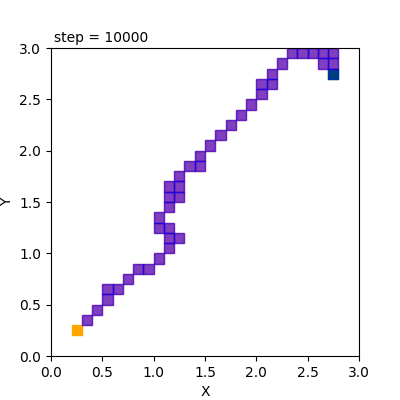

In [3]:
time_span = 1000
time_interval = 0.1

grid_step = np.array([0.1, 0.1])
grid_num = np.array([30, 30])

map_data = "../csvmap/map1.csv"

world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
policy = REINFORCE(world)
world.append(policy)

world.draw()
#world.ani.save('reinforce.gif', writer='pillow', fps=100)    #アニメーション保存